# Stimulations with fixed durations then a n-th randomly chosen shortened one

In [1]:
import os
import numpy as np
import MotionClouds as mc
import datetime
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import imageio
import warnings
from psychopy import visual, core, event
import MotionClouds as MC
import itertools

downscale = 1
fx, fy, ft = mc.get_grids(mc.N_X//downscale, mc.N_Y//downscale, mc.N_frame//downscale)

now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H:%M:%S")   

mc.figpath = os.path.join('sequences/MC_psychopy_var_%s'% strtime)
if not(os.path.isdir(mc.figpath)): os.mkdir(mc.figpath)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


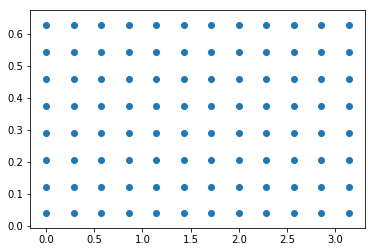

In [3]:
# Orientations
N_thetas = 12
thetas = np.linspace(0,np.pi, N_thetas) # we offset by pi/2 to prevent problems with matplotlib's displays and psychopy

# Noise
B_thetas = [np.pi/32, np.pi/16, np.pi/8, np.pi/4, np.pi/2] 


# Presentation of each pattern
stim_duration = 2 #s

# Repetition of each block
repetition = 15

#sequence at which the stims are used
random_counter = [6,13,21,27,34,42,48,55]
# duration of the shortened stim
shortened_stim = .50 # fraction of stim duration

rng = np.random.RandomState(42)
sequence = list(itertools.product(thetas, B_thetas))
rng.shuffle(sequence)

plt.scatter(*zip(*sequence))

In [3]:
print('This protocolsetup lasts for approx. [%s] minutes (not counting blanks and inter-block screens)' % (N_thetas*len(B_thetas)*stim_duration*repetition/60))
print('Each of the [%s] block lasts for [%s]s' % (repetition, stim_duration*len(sequence)))
print('using [%s] thetas and [%s] b_thetas' % (N_thetas, len(B_thetas)))
print('and presenting each pattern for [%s]s' % stim_duration)

This protocolsetup lasts for approx. [30.0] minutes (not counting blanks and inter-block screens)
Each of the [15] block lasts for [120]s
using [12] thetas and [5] b_thetas
and presenting each pattern for [2]s


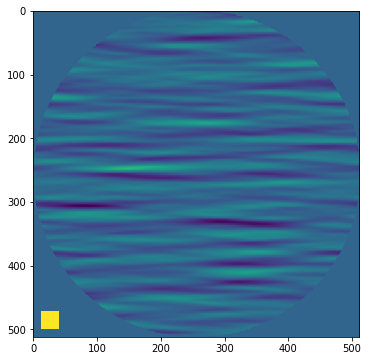

In [4]:
import imageio.core.util

def silence_imageio_warning(*args, **kwargs):
    pass

imageio.core.util._precision_warn = silence_imageio_warning

def get_keypress():
    keys = event.getKeys()
    if keys:
        return keys[0]
    else:
        return None

def generate_cloud(theta, b_theta, itr,
                   N_X, N_Y, seed, contrast=1.,
                  transition = False, save = True,
                  stim_dur = -1):
    
    fx, fy, ft = mc.get_grids(N_X, N_Y, 1)
    disk = mc.frequency_radius(fx, fy, ft) < .5

    mc_i = mc.envelope_gabor(fx, fy, ft,
                             V_X=0., V_Y=0., B_V=0.,
                             sf_0=sf_0, B_sf=B_sf,
                             theta=theta, B_theta=b_theta)

    im_ = np.zeros((N_X, N_Y,1))
    im_ += mc.rectif(mc.random_cloud(mc_i, seed=seed),
                     contrast=contrast)
    im_ *= disk  # masking outside the disk
    im_ += -.5
    im_ += .5*(1-disk)  # gray outside the disk

    if transition : im_[472:500, 12:40] = 1
    else : im_[472:500, 12:40] = -.25

    # data appending
    if save :
        with open(mc.figpath+'/sequence.csv', "a+") as writer_file:
            data_writer = csv.writer(
                writer_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            data_writer.writerow([itr, theta, b_theta, stim_dur, sf_0, B_sf, N_X, N_Y])
            
        imageio.imwrite(mc.figpath+'/%s.png' % itr, im_[:,:,0])

    return im_

width = 29.7*256/1050
N_X, N_Y = 512, 512
sf_0 = 4*width/N_X/2
B_sf = sf_0
im = generate_cloud(sequence[0][0], sequence[0][1], 1, N_X, N_Y, 42, transition = True, save = False, stim_dur= -1)

plt.figure(figsize = (12,6))
plt.imshow(im[:,:,0])

In [5]:
# Initializing PsychoPy window
win = visual.Window(fullscr=True, color=[0.0075,0.0075,0.0075], winType='pygame', monitor='testMonitor', units='height')
mouse = event.Mouse(visible=False)

MC_temp = generate_cloud(theta = np.pi/2, b_theta=np.pi/2, contrast = 1, 
                        N_X = N_X, N_Y = N_Y, seed = 42, transition = False, itr = 0, save = False)
bitmap1 = visual.ImageStim(win, MC_temp, size=1, units='height', flipVert = True)
bitmap1.autolog = False
bitmap2 = visual.ImageStim(win, MC_temp, size=1, units='height', flipVert = True)
bitmap2.autolog = False

bitmap3 = visual.ImageStim(win, MC_temp, size=1, units='height')
bitmap3.autolog = False
bitmap3.setImage(np.full((512,512), -1))


for stimulations in range(len(sequence)*repetition):
    trial = stimulations%len(sequence) # converting total stimulations in intra-block trial
    
    if trial in random_counter :
        stim_duration = shortened_stim * stim_duration
    else :
        stim_duration = 2
    
    #Waiting 5s at the beginning of a new block
    clock0 = core.Clock()
    if trial == 0 :
        
        print('Beginning new block, drawing blackscreen.')
        while clock0.getTime() < stim_duration*3 :
            bitmap3.draw()
            win.flip()
        
            
    clock = core.Clock()
    print('Trial no. %s, duration %s' % (trial, stim_duration))
    
    #stim
    MC1 = generate_cloud(theta = sequence[trial][0], b_theta=sequence[trial][1], contrast = 1, 
                        N_X = N_X, N_Y = N_Y, seed = 42, transition = False, itr = stimulations, save = True,
                        stim_dur = stim_duration,)[:,:,0]
    bitmap1.setImage(MC1)
    
    #stim with square for 6 frames before jump
    MC2 = generate_cloud(theta = sequence[trial][0], b_theta=sequence[trial][1], contrast = 1, 
                        N_X = N_X, N_Y = N_Y, seed = 42, transition = True, itr = stimulations, save = False,
                        stim_dur = -1,)[:,:,0]
    bitmap2.setImage(MC2)
    
    #early terminator
    key = get_keypress()
    if key == 'escape' : 
        win.close()
        core.quit()
        
    #timing one presentation, it works perfectly fine
    while clock.getTime() < stim_duration + .1:
        if 0.0 <= clock.getTime() < stim_duration:  # fixation
            bitmap1.draw()
        if stim_duration <= clock.getTime() < stim_duration + .1:
            bitmap2.draw()
        win.flip()       

win.close()

Beginning new block, drawing blackscreen.
Trial no. 0, duration 2
Trial no. 1, duration 2
Trial no. 2, duration 2
Trial no. 3, duration 2
Trial no. 4, duration 2
Trial no. 5, duration 2
Trial no. 6, duration 1.2
Trial no. 7, duration 2
Trial no. 8, duration 2
Trial no. 9, duration 2
Trial no. 10, duration 2
Trial no. 11, duration 2
Trial no. 12, duration 2
Trial no. 13, duration 1.2
Trial no. 14, duration 2
Trial no. 15, duration 2
Trial no. 16, duration 2
Trial no. 17, duration 2
Trial no. 18, duration 2
Trial no. 19, duration 2
Trial no. 20, duration 2
Trial no. 21, duration 1.2
Trial no. 22, duration 2
Trial no. 23, duration 2
Trial no. 24, duration 2
Trial no. 25, duration 2
Trial no. 26, duration 2
Trial no. 27, duration 1.2
Trial no. 28, duration 2
Trial no. 29, duration 2
Trial no. 30, duration 2
Trial no. 31, duration 2
Trial no. 32, duration 2
Trial no. 33, duration 2
Trial no. 34, duration 1.2
Trial no. 35, duration 2
Trial no. 36, duration 2
Trial no. 37, duration 2
Trial no

Trial no. 17, duration 2
Trial no. 18, duration 2
Trial no. 19, duration 2
Trial no. 20, duration 2
Trial no. 21, duration 1.2
Trial no. 22, duration 2
Trial no. 23, duration 2
Trial no. 24, duration 2
Trial no. 25, duration 2
Trial no. 26, duration 2
Trial no. 27, duration 1.2
Trial no. 28, duration 2
Trial no. 29, duration 2
Trial no. 30, duration 2
Trial no. 31, duration 2
Trial no. 32, duration 2
Trial no. 33, duration 2
Trial no. 34, duration 1.2
Trial no. 35, duration 2
Trial no. 36, duration 2
Trial no. 37, duration 2
Trial no. 38, duration 2
Trial no. 39, duration 2
Trial no. 40, duration 2
Trial no. 41, duration 2
Trial no. 42, duration 1.2
Trial no. 43, duration 2
Trial no. 44, duration 2
Trial no. 45, duration 2
Trial no. 46, duration 2
Trial no. 47, duration 2
Trial no. 48, duration 1.2
Trial no. 49, duration 2
Trial no. 50, duration 2
Trial no. 51, duration 2
Trial no. 52, duration 2
Trial no. 53, duration 2
Trial no. 54, duration 2
Trial no. 55, duration 1.2
Trial no. 56,

Trial no. 35, duration 2
Trial no. 36, duration 2
Trial no. 37, duration 2
Trial no. 38, duration 2
Trial no. 39, duration 2
Trial no. 40, duration 2
Trial no. 41, duration 2
Trial no. 42, duration 1.2
Trial no. 43, duration 2
Trial no. 44, duration 2
Trial no. 45, duration 2
Trial no. 46, duration 2
Trial no. 47, duration 2
Trial no. 48, duration 1.2
Trial no. 49, duration 2
Trial no. 50, duration 2
Trial no. 51, duration 2
Trial no. 52, duration 2
Trial no. 53, duration 2
Trial no. 54, duration 2
Trial no. 55, duration 1.2
Trial no. 56, duration 2
Trial no. 57, duration 2
Trial no. 58, duration 2
Trial no. 59, duration 2
Beginning new block, drawing blackscreen.
Trial no. 0, duration 2
Trial no. 1, duration 2
Trial no. 2, duration 2
Trial no. 3, duration 2
Trial no. 4, duration 2
Trial no. 5, duration 2
Trial no. 6, duration 1.2
Trial no. 7, duration 2
Trial no. 8, duration 2
Trial no. 9, duration 2
Trial no. 10, duration 2
Trial no. 11, duration 2
Trial no. 12, duration 2
Trial no. 